In [6]:
!pip install opendatasets

In [8]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sovitrath/neu-steel-surface-defect-detect-trainvalid-split")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sovitrath/neu-steel-surface-defect-detect-trainvalid-split


100%|██████████| 26.3M/26.3M [00:00<00:00, 79.0MB/s]


In [9]:
%%capture
!pip install super-gradients==3.1.0

In [11]:
!pip install super_gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.1 MB/s eta 0:00:00
  Using cached boto3-1.34.144-py3-none-any.whl (139 kB)
  Using cached coverage-5.3.1-cp310-cp310-linux_x86_64.whl
  Using cached Sphinx-4.0.3-py3-none-any.whl (2.9 MB)
  Using cached sphinx_rtd_theme-2.0.0-py2.py3-none-any.whl (2.8 MB)
  Using cached torchmetrics-0.8.0-py3-none-any.whl (408 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 109.6 MB/s eta 0:00:00
  Using cached einops-0.3.2-py3-none-any.whl (25 kB)
  Using cached treelib-1.6.1-py3-none-any.whl
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached stringcase-1.2.0-py3-none-any.whl
  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2

In [1]:
import os
from pathlib import Path
from typing import Dict, Union
import xml.etree.ElementTree as ET
import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2024-07-17 18:20:38] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-07-17 18:20:43] INFO - utils.py - NumExpr defaulting to 12 threads.


In [2]:
def convert_xml_to_yolo(xml_folder: Union[str, Path], output_folder: Union[str, Path], class_mapping: Dict[str, int]) -> None:
    """
    Convert XML annotations to YOLO format.

    Parameters:
    - xml_folder (Union[str, Path]): Path to the folder containing the XML annotation files.
    - output_folder (Union[str, Path]): Path to the folder where the YOLO annotation files will be saved.
    - class_mapping (Dict[str, int]): Dictionary mapping class names to integer class indices.

    Returns:
    None
    """
    # Convert the input folders to Path objects
    xml_folder = Path(xml_folder)
    output_folder = Path(output_folder)

    # Create the output folder if it does not exist
    output_folder.mkdir(parents=True, exist_ok=True)

    # Iterate through the files in the xml_folder
    for xml_file in xml_folder.glob("*.xml"):
        # Parse the XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get the image size
        size = root.find("size")
        img_width = int(size.find("width").text)
        img_height = int(size.find("height").text)

        # Create a new text file for the YOLO annotations
        yolo_filename = xml_file.with_suffix(".txt").name
        yolo_file_path = output_folder / yolo_filename
        with open(yolo_file_path, "w") as yolo_file:
            for obj in root.iter("object"):
                # Get the class name and index
                class_name = obj.find("name").text
                class_index = class_mapping[class_name]

                # Get the bounding box coordinates
                box = obj.find("bndbox")
                xmin = int(box.find("xmin").text)
                ymin = int(box.find("ymin").text)
                xmax = int(box.find("xmax").text)
                ymax = int(box.find("ymax").text)

                # Calculate the YOLO-format coordinates and dimensions
                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                # Write the annotation in YOLO format
                yolo_file.write(f"{class_index} {x_center} {y_center} {width} {height}\n")

class_mapping = {
    "crazing": 0,
    "inclusion": 1,
    "patches": 2,
    "pitted_surface": 3,
    "rolled-in_scale": 4,
    "scratches": 5,
}

In [3]:
# Convert the XML annotations to YOLOv5 format
convert_xml_to_yolo(xml_folder="/content/neu-steel-surface-defect-detect-trainvalid-split/train_annotations",
                    output_folder="./train_annotations",
                    class_mapping=class_mapping)


convert_xml_to_yolo(xml_folder="/content/neu-steel-surface-defect-detect-trainvalid-split/valid_annotations",
                    output_folder="./valid_annotations",
                    class_mapping=class_mapping)

In [4]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'steele-defect-detection' #specify the experiment name

    #dataset params
    DATA_DIR = '.' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train_images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train_annotations' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'valid_images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid_annotations' #child dir of DATA_DIR where validation labels are


    CLASSES = list(class_mapping.keys()) #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }


    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [5]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [7]:
!cp -r /content/neu-steel-surface-defect-detect-trainvalid-split/train_images .
!cp -r /content/neu-steel-surface-defect-detect-trainvalid-split/valid_images .

In [8]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-07-17 18:22:46] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1700/1700 [00:00<00:00, 5395.28it/s]
[2024-07-17 18:22:47] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 100/100 [00:00<00:00, 5858.78it/s]


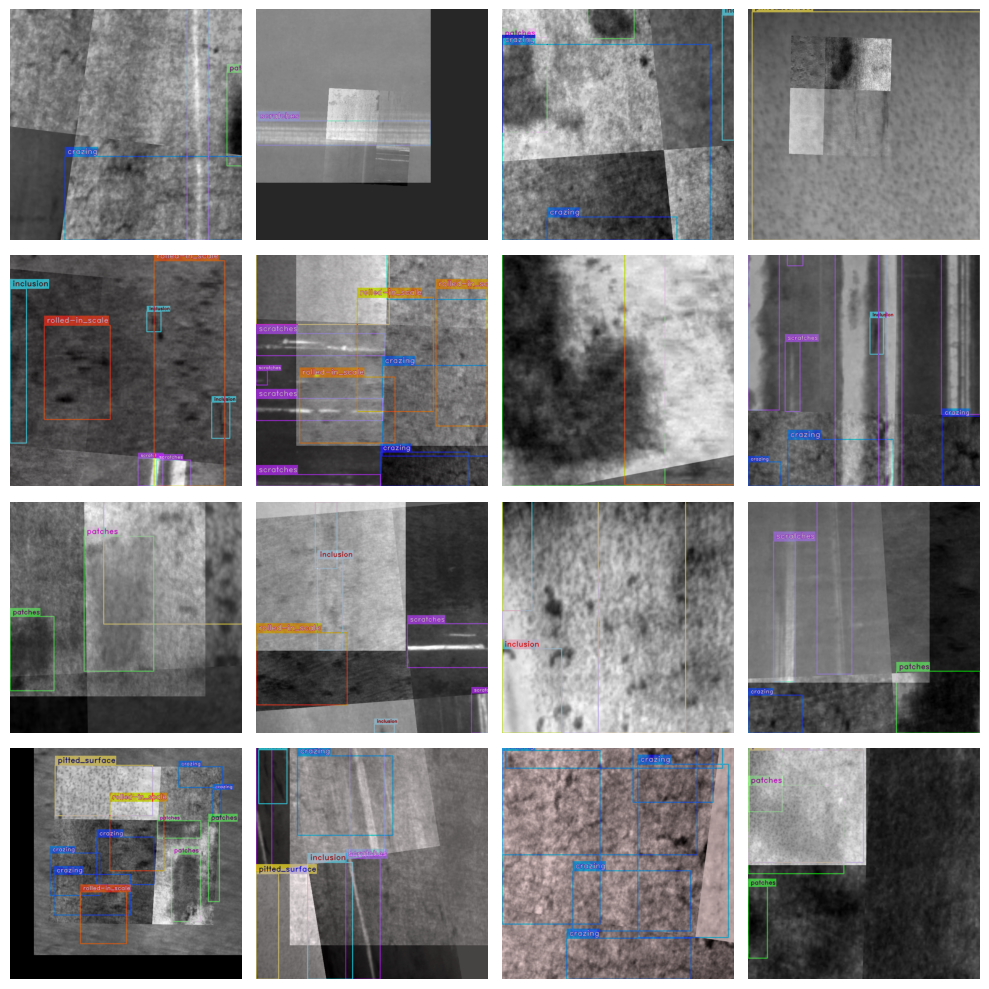

In [9]:
train_data.dataset.plot()

In [10]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2024-07-17 18:23:42] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-07-17 18:23:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:07<00:00, 36.1MB/s]
[2024-07-17 18:23:51] INFO - checkpoin

In [11]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [12]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-07-17 18:24:29] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240717_182429_339226`
[2024-07-17 18:24:29] INFO - sg_trainer.py - Checkpoints directory: checkpoints/steele-defect-detection/RUN_20240717_182429_339226
[2024-07-17 18:24:29] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixe

The console stream is now moved to checkpoints/steele-defect-detection/RUN_20240717_182429_339226/console_Jul17_18_24_29.txt


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-07-17 18:24:32] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1700       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         106        (len(train_loader))
    - Gradient updates per epoch:   106        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - L

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.0003
│   ├── Ppyoloeloss/loss_iou = 0.8137
│   ├── Ppyoloeloss/loss_dfl = 0.8989
│   └── Ppyoloeloss/loss = 3.7129
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.96
    ├── Ppyoloeloss/loss_iou = 0.832
    ├── Ppyoloeloss/loss_dfl = 0.9002
    ├── Ppyoloeloss/loss = 3.6923
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0101
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.0



Validating epoch 1: 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]
[2024-07-17 18:27:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:27:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.26699379086494446


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4044
│   │   ├── Epoch N-1      = 2.0003 (↘ -0.5959)
│   │   └── Best until now = 2.0003 (↘ -0.5959)
│   ├── Ppyoloeloss/loss_iou = 0.7061
│   │   ├── Epoch N-1      = 0.8137 (↘ -0.1076)
│   │   └── Best until now = 0.8137 (↘ -0.1076)
│   ├── Ppyoloeloss/loss_dfl = 0.8234
│   │   ├── Epoch N-1      = 0.8989 (↘ -0.0755)
│   │   └── Best until now = 0.8989 (↘ -0.0755)
│   └── Ppyoloeloss/loss = 2.934
│       ├── Epoch N-1      = 3.7129 (↘ -0.7789)
│       └── Best until now = 3.7129 (↘ -0.7789)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6883
    │   ├── Epoch N-1      = 1.96   (↘ -0.2717)
    │   └── Best until now = 1.96   (↘ -0.2717)
    ├── Ppyoloeloss/loss_iou = 0.6226
    │   ├── Epoch N-1      = 0.832  (↘ -0.2094)
    │   └── Best until now = 0.832  (↘ -0.2094)
    ├── Ppyoloeloss/loss_dfl = 0.7921
    │   ├── Epoch N-1      = 0.9002 (↘ -0.1081)
    │   └── Best until now = 0.9002 (↘ -0.1081)
    ├── Ppyoloeloss/los

Validating epoch 2: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]
[2024-07-17 18:28:49] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:28:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3233586549758911


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3091
│   │   ├── Epoch N-1      = 1.4044 (↘ -0.0953)
│   │   └── Best until now = 1.4044 (↘ -0.0953)
│   ├── Ppyoloeloss/loss_iou = 0.6715
│   │   ├── Epoch N-1      = 0.7061 (↘ -0.0346)
│   │   └── Best until now = 0.7061 (↘ -0.0346)
│   ├── Ppyoloeloss/loss_dfl = 0.8033
│   │   ├── Epoch N-1      = 0.8234 (↘ -0.0201)
│   │   └── Best until now = 0.8234 (↘ -0.0201)
│   └── Ppyoloeloss/loss = 2.7839
│       ├── Epoch N-1      = 2.934  (↘ -0.15)
│       └── Best until now = 2.934  (↘ -0.15)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5258
    │   ├── Epoch N-1      = 1.6883 (↘ -0.1625)
    │   └── Best until now = 1.6883 (↘ -0.1625)
    ├── Ppyoloeloss/loss_iou = 0.6223
    │   ├── Epoch N-1      = 0.6226 (↘ -0.0003)
    │   └── Best until now = 0.6226 (↘ -0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.7827
    │   ├── Epoch N-1      = 0.7921 (↘ -0.0094)
    │   └── Best until now = 0.7921 (↘ -0.0094)
    ├── Ppyoloeloss/loss =

Validating epoch 3: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]
[2024-07-17 18:30:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:30:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.348819375038147


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2973
│   │   ├── Epoch N-1      = 1.3091 (↘ -0.0118)
│   │   └── Best until now = 1.3091 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.645
│   │   ├── Epoch N-1      = 0.6715 (↘ -0.0265)
│   │   └── Best until now = 0.6715 (↘ -0.0265)
│   ├── Ppyoloeloss/loss_dfl = 0.7856
│   │   ├── Epoch N-1      = 0.8033 (↘ -0.0177)
│   │   └── Best until now = 0.8033 (↘ -0.0177)
│   └── Ppyoloeloss/loss = 2.7279
│       ├── Epoch N-1      = 2.7839 (↘ -0.0561)
│       └── Best until now = 2.7839 (↘ -0.0561)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5728
    │   ├── Epoch N-1      = 1.5258 (↗ 0.047)
    │   └── Best until now = 1.5258 (↗ 0.047)
    ├── Ppyoloeloss/loss_iou = 0.5964
    │   ├── Epoch N-1      = 0.6223 (↘ -0.0259)
    │   └── Best until now = 0.6223 (↘ -0.0259)
    ├── Ppyoloeloss/loss_dfl = 0.7768
    │   ├── Epoch N-1      = 0.7827 (↘ -0.0059)
    │   └── Best until now = 0.7827 (↘ -0.0059)
    ├── Ppyoloeloss/loss = 

Validating epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]
[2024-07-17 18:31:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:31:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.37205445766448975


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.271
│   │   ├── Epoch N-1      = 1.2973 (↘ -0.0263)
│   │   └── Best until now = 1.2973 (↘ -0.0263)
│   ├── Ppyoloeloss/loss_iou = 0.617
│   │   ├── Epoch N-1      = 0.645  (↘ -0.0281)
│   │   └── Best until now = 0.645  (↘ -0.0281)
│   ├── Ppyoloeloss/loss_dfl = 0.762
│   │   ├── Epoch N-1      = 0.7856 (↘ -0.0236)
│   │   └── Best until now = 0.7856 (↘ -0.0236)
│   └── Ppyoloeloss/loss = 2.65
│       ├── Epoch N-1      = 2.7279 (↘ -0.0779)
│       └── Best until now = 2.7279 (↘ -0.0779)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.546
    │   ├── Epoch N-1      = 1.5728 (↘ -0.0269)
    │   └── Best until now = 1.5258 (↗ 0.0201)
    ├── Ppyoloeloss/loss_iou = 0.5668
    │   ├── Epoch N-1      = 0.5964 (↘ -0.0297)
    │   └── Best until now = 0.5964 (↘ -0.0297)
    ├── Ppyoloeloss/loss_dfl = 0.7313
    │   ├── Epoch N-1      = 0.7768 (↘ -0.0454)
    │   └── Best until now = 0.7768 (↘ -0.0454)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 5: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]
[2024-07-17 18:33:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:33:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4201851785182953


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.255
│   │   ├── Epoch N-1      = 1.271  (↘ -0.016)
│   │   └── Best until now = 1.271  (↘ -0.016)
│   ├── Ppyoloeloss/loss_iou = 0.593
│   │   ├── Epoch N-1      = 0.617  (↘ -0.024)
│   │   └── Best until now = 0.617  (↘ -0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.7507
│   │   ├── Epoch N-1      = 0.762  (↘ -0.0114)
│   │   └── Best until now = 0.762  (↘ -0.0114)
│   └── Ppyoloeloss/loss = 2.5986
│       ├── Epoch N-1      = 2.65   (↘ -0.0514)
│       └── Best until now = 2.65   (↘ -0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3636
    │   ├── Epoch N-1      = 1.546  (↘ -0.1824)
    │   └── Best until now = 1.5258 (↘ -0.1623)
    ├── Ppyoloeloss/loss_iou = 0.5592
    │   ├── Epoch N-1      = 0.5668 (↘ -0.0076)
    │   └── Best until now = 0.5668 (↘ -0.0076)
    ├── Ppyoloeloss/loss_dfl = 0.7412
    │   ├── Epoch N-1      = 0.7313 (↗ 0.0098)
    │   └── Best until now = 0.7313 (↗ 0.0098)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 6: 100%|██████████| 6/6 [00:03<00:00,  1.99it/s]
[2024-07-17 18:34:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:34:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.47291994094848633


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2209
│   │   ├── Epoch N-1      = 1.255  (↘ -0.0341)
│   │   └── Best until now = 1.255  (↘ -0.0341)
│   ├── Ppyoloeloss/loss_iou = 0.567
│   │   ├── Epoch N-1      = 0.593  (↘ -0.026)
│   │   └── Best until now = 0.593  (↘ -0.026)
│   ├── Ppyoloeloss/loss_dfl = 0.7223
│   │   ├── Epoch N-1      = 0.7507 (↘ -0.0283)
│   │   └── Best until now = 0.7507 (↘ -0.0283)
│   └── Ppyoloeloss/loss = 2.5102
│       ├── Epoch N-1      = 2.5986 (↘ -0.0884)
│       └── Best until now = 2.5986 (↘ -0.0884)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4124
    │   ├── Epoch N-1      = 1.3636 (↗ 0.0488)
    │   └── Best until now = 1.3636 (↗ 0.0488)
    ├── Ppyoloeloss/loss_iou = 0.5421
    │   ├── Epoch N-1      = 0.5592 (↘ -0.0171)
    │   └── Best until now = 0.5592 (↘ -0.0171)
    ├── Ppyoloeloss/loss_dfl = 0.7229
    │   ├── Epoch N-1      = 0.7412 (↘ -0.0182)
    │   └── Best until now = 0.7313 (↘ -0.0084)
    ├── Ppyoloeloss/loss = 

Validating epoch 7: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]
[2024-07-17 18:36:19] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:36:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5237172245979309


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2081
│   │   ├── Epoch N-1      = 1.2209 (↘ -0.0129)
│   │   └── Best until now = 1.2209 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_iou = 0.5537
│   │   ├── Epoch N-1      = 0.567  (↘ -0.0133)
│   │   └── Best until now = 0.567  (↘ -0.0133)
│   ├── Ppyoloeloss/loss_dfl = 0.7093
│   │   ├── Epoch N-1      = 0.7223 (↘ -0.013)
│   │   └── Best until now = 0.7223 (↘ -0.013)
│   └── Ppyoloeloss/loss = 2.4711
│       ├── Epoch N-1      = 2.5102 (↘ -0.0392)
│       └── Best until now = 2.5102 (↘ -0.0392)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3048
    │   ├── Epoch N-1      = 1.4124 (↘ -0.1075)
    │   └── Best until now = 1.3636 (↘ -0.0587)
    ├── Ppyoloeloss/loss_iou = 0.5366
    │   ├── Epoch N-1      = 0.5421 (↘ -0.0055)
    │   └── Best until now = 0.5421 (↘ -0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.7164
    │   ├── Epoch N-1      = 0.7229 (↘ -0.0066)
    │   └── Best until now = 0.7229 (↘ -0.0066)
    ├── Ppyoloeloss/loss

Validating epoch 8: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]
[2024-07-17 18:37:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:37:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5330097079277039


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1921
│   │   ├── Epoch N-1      = 1.2081 (↘ -0.016)
│   │   └── Best until now = 1.2081 (↘ -0.016)
│   ├── Ppyoloeloss/loss_iou = 0.5359
│   │   ├── Epoch N-1      = 0.5537 (↘ -0.0178)
│   │   └── Best until now = 0.5537 (↘ -0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.6943
│   │   ├── Epoch N-1      = 0.7093 (↘ -0.015)
│   │   └── Best until now = 0.7093 (↘ -0.015)
│   └── Ppyoloeloss/loss = 2.4222
│       ├── Epoch N-1      = 2.4711 (↘ -0.0488)
│       └── Best until now = 2.4711 (↘ -0.0488)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2626
    │   ├── Epoch N-1      = 1.3048 (↘ -0.0423)
    │   └── Best until now = 1.3048 (↘ -0.0423)
    ├── Ppyoloeloss/loss_iou = 0.5091
    │   ├── Epoch N-1      = 0.5366 (↘ -0.0275)
    │   └── Best until now = 0.5366 (↘ -0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.6981
    │   ├── Epoch N-1      = 0.7164 (↘ -0.0183)
    │   └── Best until now = 0.7164 (↘ -0.0183)
    ├── Ppyoloeloss/loss =

Validating epoch 9: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]
[2024-07-17 18:39:24] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/steele-defect-detection/RUN_20240717_182429_339226/ckpt_best.pth
[2024-07-17 18:39:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5392166972160339


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1787
│   │   ├── Epoch N-1      = 1.1921 (↘ -0.0133)
│   │   └── Best until now = 1.1921 (↘ -0.0133)
│   ├── Ppyoloeloss/loss_iou = 0.5278
│   │   ├── Epoch N-1      = 0.5359 (↘ -0.008)
│   │   └── Best until now = 0.5359 (↘ -0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.6927
│   │   ├── Epoch N-1      = 0.6943 (↘ -0.0016)
│   │   └── Best until now = 0.6943 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.3993
│       ├── Epoch N-1      = 2.4222 (↘ -0.023)
│       └── Best until now = 2.4222 (↘ -0.023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2975
    │   ├── Epoch N-1      = 1.2626 (↗ 0.0349)
    │   └── Best until now = 1.2626 (↗ 0.0349)
    ├── Ppyoloeloss/loss_iou = 0.5142
    │   ├── Epoch N-1      = 0.5091 (↗ 0.0051)
    │   └── Best until now = 0.5091 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.7008
    │   ├── Epoch N-1      = 0.6981 (↗ 0.0027)
    │   └── Best until now = 0.6981 (↗ 0.0027)
    ├── Ppyoloeloss/loss = 2.512

[2024-07-17 18:39:35] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


In [15]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path= "/content/checkpoints/steele-defect-detection/RUN_20240717_182429_339226/average_model.pth")

In [16]:
trainer.test(model=best_model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  83%|████████▎ | 5/6 [00:02<00:00,  1.92it/s]

{'PPYoloELoss/loss_cls': 1.2581154,
 'PPYoloELoss/loss_iou': 0.5107932,
 'PPYoloELoss/loss_dfl': 0.68390226,
 'PPYoloELoss/loss': 2.452811,
 'Precision@0.50': 0.0396382100880146,
 'Recall@0.50': 0.9637815356254578,
 'mAP@0.50': 0.5003913640975952,
 'F1@0.50': 0.07534285634756088,
 'Best_score_threshold': 0.26999998092651367}

Testing: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


[2024-07-17 18:41:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


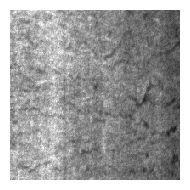

/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


In [17]:
best_model.predict('train_images/crazing_10.jpg', conf=0.3).show()